# Hierarchical Example

The "rat tumor" example from Bayesian Data Analysis (3rd edition), Section 5.1 and 5.4

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import emcee
import scipy.special

The setup is that we have performed a series of "exchangable" experiments, in each case giving:

- A total count, say $N_i$, of the rats we performed the experiment on.
- A count, $0 \leq n_i \leq N_i$, of rats which did something.  (In this case, developed a tumour).

Our model is that of a binomial model for the number of tumours, with unknown parameter $\theta$.  As a prior on $\theta$ we use a conjugate family, namely $\operatorname{Beta}(\alpha,\beta)$.  We will discuss a hyper-prior on $\alpha,\beta$ later.

In [2]:
previous_experiments = [ (0,20), (0,20), (0,20), (0,20), (0,20), (0,20), (0,20), (0,19), (0,19), (0,19),
    (0,19), (0,18), (0,18), (0,17), (1,20), (1,20), (1,20), (1,20), (1,19), (1,19),
    (1,18), (1,18), (2,25), (2,24), (2,23), (2,20), (2,20), (2,20), (2,20), (2,20),
    (2,20), (1,10), (5,49), (2,19), (5,46), (3,27), (2,17), (7,49), (7,47), (3,20),
    (3,20), (2,13), (9,48), (10,50), (4,20), (4,20), (4,20), (4,20), (4,20), (4,20),
    (4,20), (10,48), (4,19), (4,19), (4,19), (5,22), (11,46), (12,49), (5,20), (5,20),
    (6,23), (5,19), (6,22), (6,20), (6,20), (6,20), (16,52), (15,47), (15,46), (9,24) ]

new_experiment = (4,14)

As a first step, rather than putting a hyper-prior on $\alpha, \beta$ we try instead to find a point estimate.  Following the book, we use the [method of moments](https://en.wikipedia.org/wiki/Method_of_moments_%28statistics%29).

The mean and variance of a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with parameters $\alpha, \beta$ are
$$ \newcommand{\var}{\operatorname{var}}
\mathbb E(\theta) = \frac{\alpha}{\alpha + \beta}, \quad
\var(\theta) = \frac{\alpha\beta}{(\alpha+\beta)^2(\alpha+\beta+1)}. $$
Solving these gives
$$ \alpha + \beta = \frac{\mathbb E(\theta) (1-\mathbb E(\theta))}{\var(\theta)} - 1,\quad
\alpha = (\alpha+\beta)\mathbb E(\theta), \quad
\beta = (\alpha+\beta)(1-\mathbb E(\theta)). $$

In [3]:
mean_ratio = np.mean([n/N for n,N in previous_experiments])
std_ratio = np.std([n/N for n,N in previous_experiments], ddof=1)
mean_ratio, std_ratio

(0.13600653889043893, 0.10349226979832518)

In [4]:
ab = mean_ratio * (1-mean_ratio) / std_ratio**2 - 1
alpha = ab * mean_ratio
beta = ab * (1-mean_ratio)
alpha, beta

(1.3561493910319331, 8.615057891320788)

We now briefly consider what effect the new observation has on the alpha and beta values.  That is, we use the above estimated values of $\alpha, \beta$ to form a prior distribution, and then use the "new experiment" to form a posterior.  The posterior mean is smaller than the point estimate from the experiement (4/14) because the of the influence of the earlier experiments.  We interpret this to mean that the new experiment has an unusually large tumour count.

In [5]:
post_alpha = alpha + new_experiment[0]
post_beta = beta + new_experiment[1] - new_experiment[0]
post_alpha, post_beta

(5.3561493910319333, 18.615057891320788)

In [6]:
postab = post_alpha + post_beta
post_mean = post_alpha / postab
post_var = post_alpha * post_beta / (postab * postab * (postab+1))
post_mean, np.sqrt(post_var)

(0.22344095263716893, 0.083358301946923063)

In [7]:
4/14

0.2857142857142857

# Fully Bayesian approach

We now consider a fully bayesian approach and put a prior distribution (a "hyper-prior") on the parameters $\alpha,\beta$ of the Beta prior to the Binomial.  Here there is no closed form solution.  The book looks at point estimates on a grid, and then draws contour lines from this.  We use an MCMC approach instead.

In [8]:
nwalkers = 100
ndim = 2
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [9]:
def log_likelihood(x):
    """x is (log(alpha/beta), log(alpha+beta))"""
    a, b = np.exp(x)
    beta = b / (1 + a)
    alpha = a * beta
    p = np.log(alpha) + np.log(beta) - 2.5 * np.log(alpha + beta)
    def lg(x):
        return scipy.special.loggamma(x).real
    p += len(previous_experiments) * (lg(alpha + beta) - lg(alpha) - lg(beta))
    # This could be sped up with numpy magic
    for n, N in previous_experiments:
        p += lg(alpha + n) + lg(beta + N - n) - lg(alpha + beta + N)
    return p

In [10]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=())

In [11]:
pos, prob, state = sampler.run_mcmc(p0, 20)
sampler.reset()

In [12]:
_ = sampler.run_mcmc(pos, 1000)

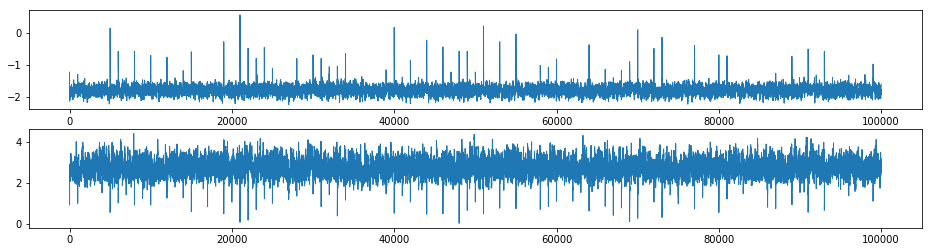

In [13]:
fig, axes = plt.subplots(nrows=ndim, figsize=(16,2*ndim))
for i in range(ndim):
    axes[i].plot(sampler.flatchain[:,i], linewidth=1)

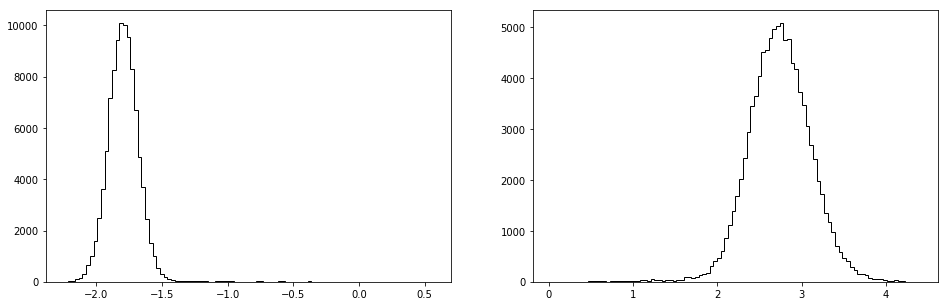

In [14]:
fig, axes = plt.subplots(ncols=ndim, figsize=(16,5))

for i in range(ndim):
    axes[i].hist(sampler.flatchain[:,i], 100, color="k", histtype="step")

Count in a 2 dimensional histogram.

In [15]:
xcs = np.linspace(-2.3, -1.3, 41)
ycs = np.linspace(1, 5, 41)
count_matrix = np.zeros((ycs.shape[0] - 1, xcs.shape[0] - 1))
for i, y1 in enumerate(ycs[:-1]):
    y2 = ycs[i+1]
    for j, x1 in enumerate(xcs[:-1]):
        x2 = xcs[j+1]
        mask = (sampler.flatchain[:,0] >= x1) & (sampler.flatchain[:,0] < x2)
        mask &= (sampler.flatchain[:,1] >= y1) & (sampler.flatchain[:,1] < y2)
        count_matrix[i,j] = np.sum(mask) / sampler.flatchain.shape[0]

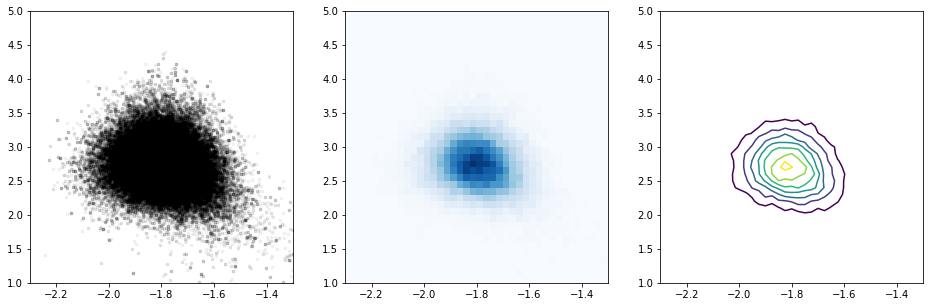

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

axes[0].scatter(*sampler.flatchain.T, marker=".", color="black", linewidth=0.5, alpha=0.05)
axes[1].pcolorfast(xcs, ycs, count_matrix, cmap="Blues", rasterized=True)
axes[2].contour(xcs[:-1], ycs[:-1], count_matrix)

for ax in axes:
    ax.set(xlim=[-2.3, -1.3], ylim=[1,5])

For each sample, convert back to $(\alpha, \beta)$ space, and then draw a sample from the Beta distribution.  This gives us samples from the combined distribution for $\theta$ the parameter of the Binomial.  We compare the resulting histogram with that produced from the point estimate we obtained above for $\alpha,\beta$.

In [17]:
thetas = []

for x in sampler.flatchain:
    a, b = np.exp(x)
    beta = b / (1 + a)
    alpha = a * beta
    thetas.append( np.random.beta(alpha, beta) )
    
thetas = np.asarray(thetas)

In [18]:
n = sum(a for a, b in previous_experiments)
N = sum(b for a, b in previous_experiments)
thetas1 = np.random.beta(0.5 + n, 0.5 + N - n, size=sampler.flatchain.shape[0])
thetas1 = np.random.beta(1.3561493910319331, 8.615057891320788, size=sampler.flatchain.shape[0])

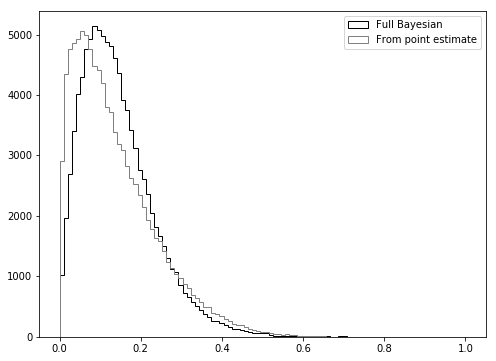

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(0, 1, 100)
ax.hist(thetas, bins, color="k", histtype="step", label="Full Bayesian")
ax.hist(thetas1, bins, color="grey", histtype="step", label="From point estimate")
ax.legend()
None